# Problemset 2:

**The R data in this homwork comes from GitHub and is linked below** 
> <a href="https://github.com/robjhyndman/fpp3package" title="fpp3package">fpp3package</a>
 & <a href="https://github.com/tidyverts/tsibbledata/" title="Wikipedia">tsibbledata</a>


**Links to documentaion for packages used**

> Pandas timeseries documention:
>https://pandas.pydata.org/docs/user_guide/timeseries.html


> Statsmodel Time Series analysis:
>https://www.statsmodels.org/stable/tsa.html

> A Python package to read and write R RData and Rds files into/from pandas data frames:
>https://pypi.org/project/pyreadr/

## Prepare Work space: 

In [1]:
#use statsforcast env

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
from matplotlib import pyplot

import pyreadr
 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, month_plot , quarter_plot , seasonal_plot

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="darkgrid")


## - Chapter 5 Excersise 6 

 **A.)** False. Normally distributed residuals can be an indication of a well-fitted model, it is not a requirement for a good forecast method. The assumption of normally distributed residuals is often made in some models, such as linear regression, but it is not true for all forecasting situations. There are various other methods such as the naive method and models that can provide accurate forecasts without assuming normally distributed residuals.

**B.)** False. Small residuals indicate that the model is fitting the data well, it does not guarantee good forecast accuracy. The performance of a forecasting model should be evaluated based on its ability to make accurate predictions on test data rather than solely focusing on the residuals of the training data. A model may overfit the training data, resulting in small residuals but poor preformace on new data. 

**C.)** False. The choice of the best measure of forecast accuracy depends on the specific context and the characteristics of the data. MAPE is commonly used, but it has some limitations, such as being sensitive to zero values in the data. Other measures like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), can also be valuable in assessing forecast accuracy. It's important to consider the nature of the data and the goal of the forecasting problem when selecting an appropriate accuracy measure.

**D.)** False. Increasing the complexity of a model is not always the solution to improve forecast performance. Overcomplicating a model can lead to overfitting, where the model becomes too closely tailored to the training data and performs poorly on new data. It is essential to strike a balance between model complexity and generalization. This is sometimes called the bias variance trade off, where inceasing the model complexity will reduce bias but increase the variance on new data. 

**E.)**  True but depending on the situation. Forecast accuracy on the test set is an important factor in model selection, it should not be the sole criterion. Other factors like model interpretability, computational efficiency, ease of implementation and data requirements. Depending on the specific context, a model with slightly lower forecast accuracy on the test set may be preferred if it offers other advantages or aligns better with the goals of the forecasting problem. 

## - Chapter 8 Excersise 8 

Recall your retail time series data (from Exercise 8 in Section 2.10).

 **A.)** Why is multiplicative seasonality necessary for this series?

 **B.)** Apply Holt-Winters’ multiplicative method to the data. Experiment with making the trend damped.

 **C.)** Compare the RMSE of the one-step forecasts from the two methods. Which do you prefer?

 **D.)** Check that the residuals from the best method look like white noise.

 **E.)** Now find the test set RMSE, while training the model to the end of 2010. Can you beat the seasonal naïve approach from Exercise 7 in Section 5.11?

### - Data Upload and Preprocessing 

In [10]:
# read in the .rda file using pyreadr package  

result = pyreadr.read_r("/Users/averydavis/Desktop/Predictive_Analytics_Forecasting/Rdata/aus_retail.rda") # also works for RData
print(result.keys()) # check the objects  
df = result['aus_retail'] # extract the dataframe obeject

print("shape of data:"+str(df.shape)) 
print("number of difrent groups contained in the data frame: "+str(len(df['Series ID'].unique())))
df.head()# check data read in correctly 


odict_keys(['aus_retail'])
shape of data:(64532, 5)
number of difrent groups contained in the data frame: 152


,State,Industry,Series ID,Month,Turnover
0,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,4473.0,4.4
1,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,4503.0,3.4
2,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,4534.0,3.6
3,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,4564.0,4.0
4,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,4595.0,3.6


The data read in with a few errors that need to be fixed before procedidng further. First the data set is susposed to be a pannel data set, that means we must create a higherarchical data set based on the series ID and the time component. Basing the higherarchy on the Series ID will insure that each region and industry will have their own grouping. The time compenent is measured in months and has come through as nonsense integers. This means we will have to create a new timescale from scratch. There seem to be about 35* years worth of data for each group and we will make an assumption that all of the data starts in 1980 for the purpose of this question. 


>  *((total rows/number of groups)/12 months) ~ 35 years 

In [11]:
def process_data(df):
    try:
        # Step 1: Splitting the data into individual DataFrames based on unique 'id'
        unique_ids = df['Series ID'].unique()
        data_frames = {}

        for id_value in unique_ids:
            data_frames[id_value] = df[df['Series ID'] == id_value].copy()

        # Step 2: Creating a new DateTime index with varying lengths for each DataFrame
        start_date = pd.Timestamp('1980-01-01')

        for id_value, df in data_frames.items():
            num_observations = len(df)
            end_date = start_date + pd.DateOffset(months=num_observations )
            new_index = pd.date_range(start=start_date, end=end_date, freq='M')
            df['Month'] = new_index[:len(df)]  # Assign the new index values matching the DataFrame length
            df.set_index('Month', inplace=True)
            df = df.reindex(new_index)

        # Step 3: Reassembling the DataFrames into a higher-level DataFrame
        higher_level_df = pd.concat(data_frames.values(), keys=data_frames.keys())

        # Return the resulting higher-level DataFrame
        return higher_level_df
    #error handeling 
    except KeyError as e:
        print("KeyError:", e)
        return None


processed_data = process_data(df)

# Printing the resulting higher-level DataFrame
processed_data

State   
          Month                                      
A3349849A 1980-01-31  Australian Capital Territory  \
          1980-02-29  Australian Capital Territory   
          1980-03-31  Australian Capital Territory   
          1980-04-30  Australian Capital Territory   
          1980-05-31  Australian Capital Territory   
...                                            ...   
A3349435A 2016-05-31             Western Australia   
          2016-06-30             Western Australia   
          2016-07-31             Western Australia   
          2016-08-31             Western Australia   
          2016-09-30             Western Australia   

                                                      Industry  Series ID   
          Month                                                             
A3349849A 1980-01-31  Cafes, restaurants and catering services  A3349849A  \
          1980-02-29  Cafes, restaurants and catering services  A3349849A   
          1980-03-31  Cafes, restaurants and catering services  A3349849A   
          1980-04-30  Cafes, restaurants and catering services  A3349849A   
          1980-05-31  Cafes, restaurants and catering services  A3349849A   
...                                                        ...        ...   
A3349435A 2016-05-31                    Takeaway food services  A3349435A   
          2016-06-30                    Takeaway food services  A3349435A   
          2016-07-31                    Takeaway food services  A3349435A   
          2016-08-31                    Takeaway food services  A3349435A   
          2016-09-30                    Takeaway food services  A3349435A   

                      Turnover  
          Month                 
A3349849A 1980-01-31       4.4  
          1980-02-29       3.4  
          1980-03-31       3.6  
          1980-04-30       4.0  
          1980-05-31       3.6  
...                        ...  
A3349435A 2016-05-31     178.5  
          2016-06-30     179.8  
          2016-07-31     183.2  
          2016-08-31     183.7  
          2016-09-30     195.1  

[64532 rows x 4 columns]

<div class="alert alert-block alert-info">
<b>Note:</b> This Next step is replicating something done in a earlier homework by grabbing one of the particular time series randomly from our dataset to examine.</div>

In [27]:
# Set a static random seed for reproducibility
np.random.seed(88)

# Filter the DataFrame based on a randomly selected 'Series ID'
aus_retail = processed_data.copy()
random_series_id = np.random.choice(aus_retail['Series ID'], 1)[0]
myseries = aus_retail.loc[aus_retail['Series ID'] == random_series_id].copy()
myseries = myseries.droplevel(0)
myseries['ds'] = myseries.index
df=myseries["Turnover"]

## A.) 
> For this time series, there is expanding variation over time, adopting a multiplicative approach, specifically utilizing multiplicative seasonality, is essential to accurately capture the characteristics of the data. The multiplicative model is better suited in situations where the magnitude of fluctuations in the series changes proportionally with the trend. In other words, as the trend of the series increases, the seasonal component also grows in magnitude, reflecting the expanding variation observed in the data. This can be clearly seen in the first plot, where as the time and level increase the variance is also expanding. Unfortuanately the residual plot from the seasonal decompostion is not very helpfull in this case. 


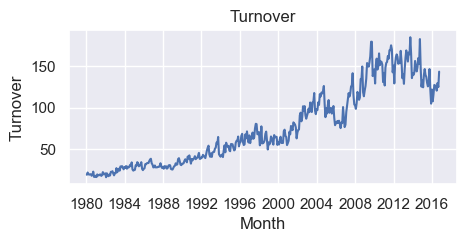

In [19]:
sns.lineplot(x="Month", y="Turnover",data=myseries)
plt.title("Turnover")
plt.rcParams["figure.figsize"] = (5,2)
plt.show()

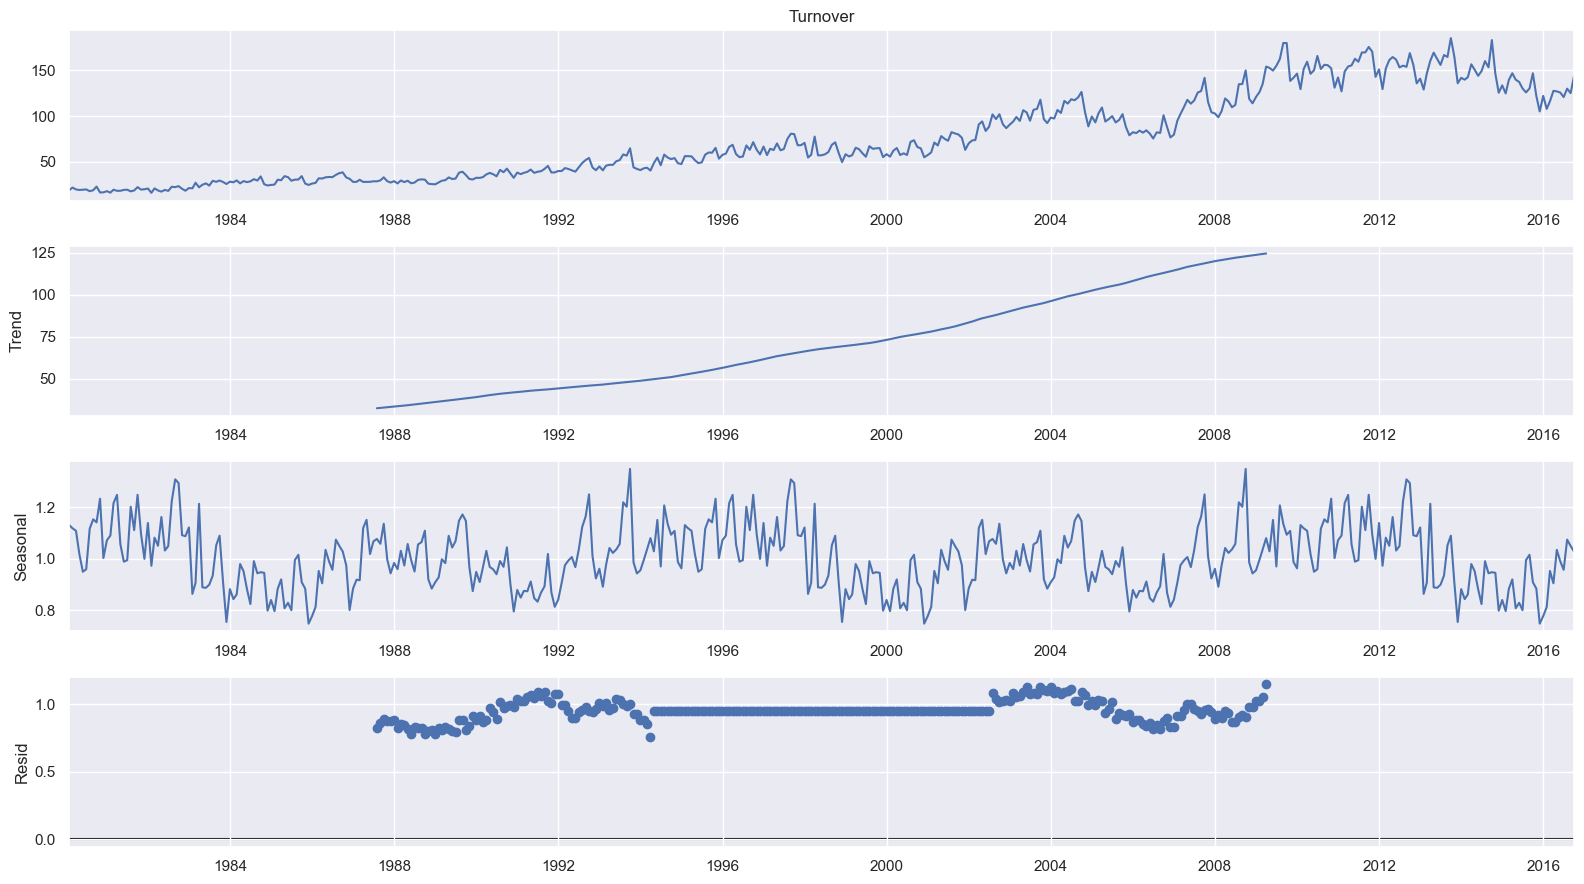

In [23]:
# seasonal decompostion 
decomp_viz = seasonal_decompose(myseries["Turnover"],model="multiplicative", period=180)
fig = decomp_viz.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

## B.) 

In [54]:
df

Month
1980-01-31     19.2
1980-02-29     21.9
1980-03-31     19.9
1980-04-30     19.3
1980-05-31     19.6
              ...  
2016-05-31    125.6
2016-06-30    120.7
2016-07-31    129.9
2016-08-31    125.0
2016-09-30    143.6
Name: Turnover, Length: 441, dtype: float64

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Apply Holt-Winters' multiplicative method with a damped trend
model_damp = ExponentialSmoothing(df, trend="mul", damped_trend=True, seasonal="mul")
fit_damp = model_damp.fit()

# Apply Holt-Winters' multiplicative method with a un-damped trend
model_dry = ExponentialSmoothing(df, trend="mul", damped_trend=False, seasonal="mul")
fit_dry = model_dry.fit()

In [43]:
fit_damp.summary()
fit_dry.summary()

Dep. Variable:,Turnover,No. Observations:,441
Model:,ExponentialSmoothing,SSE,11822.276
Optimized:,True,AIC,1482.315
Trend:,Multiplicative,BIC,1547.740
Seasonal:,Multiplicative,AICC,1483.936
Seasonal Periods:,12,Date:,"Tue, 16 May 2023"
Box-Cox:,False,Time:,22:03:09
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5445949,alpha,True
smoothing_trend,0.000000,beta,True


## C.)

In [44]:
# Calculate RMSE for both methods
rmse_damp = np.sqrt(((df - fit_damp.predict(start=1)) ** 2).mean())
rmse_dry = np.sqrt(((df - fit_dry.predict(start=1)) ** 2).mean())

# Compare RMSE and choose preferred method
if rmse_damp < rmse_dry:
    preferred_method = "Dampend trend"
else:
    preferred_method = "Un-Dampend trend"
print("Preferred Method:", preferred_method)

Preferred Method: Dampend trend


## D.)

In [68]:
from statsmodels.tsa.stattools import acf

# Calculate autocorrelation of residuals
residuals = df - fit_damp.predict(start=1)
acf_res = acf(residuals, nlags=10, fft=False)

# Check if autocorrelations are within the confidence bounds for white noise
within_bounds = np.all(np.abs(acf_res[1:]) < 1.96 / np.sqrt(len(df)))
print("Residuals Look Like White Noise:", within_bounds)


Residuals Look Like White Noise: False


## E.) 

In [58]:
rmse_damp

5.1824752148076305

## - Chapter 9 Excersise 9

 **A.)** 
 The differences among the ACF figures for the series of 36 random numbers(left), 360  random numbers(middle), and 1,000 random numbers(right) indicate variations in the properties of the data. All of the figures are representing white noise, none of the Autocorrelation lags fall outside of the critical values therefore we can be confident in our interpetation.

 **B.)** 
 The critical values in the ACF plots indicate the bounds for determining statistical significance. These values are at different distances from the mean of zero due to the influence of sample size and the level of       confidence chosen.As the sample size increases, the standard error of the autocorrelation decreases, leading to narrowerconfidence intervals. Consequently, the critical values are closer to zero in the ACF plot with 1,000 random numbers compared to the ACF plot with 36 random numbers.The autocorrelations differ in each figure because of random variability. Although all figures represent white noise, the estimated autocorrelations may deviate from zero due to randomness. The larger the sample size, the closer the estimated autocorrelations tend to converge to zero. Random variability can still cause slight fluctuations in the estimated autocorrelation values, resulting in differences among the figures.

